In [90]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys
from torchvision.utils import save_image, make_grid

# Build an Autoencoder for a human face dataset

We will use a dataset containig images of people and train an autoencoder on it. 

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [91]:

path = '/Users/visheshmehta/College/Semester2/Pr/Hw3/lfw'

In [92]:
transform    = transforms.Compose([transforms.ToTensor()]) 

## dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True) ## Removed shuffle to check the output of three models for the same input
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32)

This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [93]:
''' if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.") '''

' if torch.backends.mps.is_available():\n    device = torch.device("mps")\nelse:\n    print ("MPS device not found.") '

torch.Size([250, 250, 3])


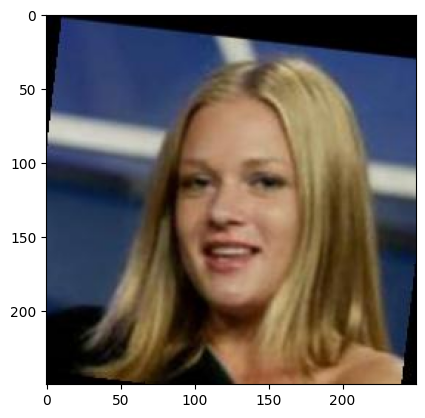

In [94]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

## Step 2
Each datapoint is an image. Get a sample of the data and print its dimensions and explain what each dimension means.

In [6]:
for x,y in dataloader:
    print(x.shape)
    break

torch.Size([32, 3, 250, 250])


* The size of the data is [32, 3, 250, 250], Let's breakdown each dimension.
* 32 is the number of batches that we provided while converting images to tensors and creating dataloader.
* Now, the shape of each image is [3, 250, 250].
* Here, first dimension represents number of color chanels. This is ans RGB image, hence the number of chanels are 3.
* The other two dimensions of the image [250, 250] are height and width respectively.
* It means the image has 250 pixels for height and width and each pixel has its red, green and blue color values, so the size of each image is [3,250,250] = [number_0f_color_chanels, pixels_in_height, pixels_in_width]

In [7]:
# Now let's look at the data that each image holds.

for x,y in dataloader:
    print(x[0].shape)
    print(x[0][0].shape)
    print(x[0][0])
    break

torch.Size([3, 250, 250])
torch.Size([250, 250])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


* First lets breakdown the varibale x[0][0].
* x[0] is the 1st image out of 32 (batch size) and henxe the dimension of it would be [3,250,250]
* x[0][0] would hold the 250 pixel values of red color for height and width. so its size will be[250,250] => values of red color for image 1.
* Here, the range of the value for each pixel is [0,1] instead of [0,255] (the range for RGB values), as we have normalized the images.

# Step 3

Create a new pytorch model calss for your autoencoder. You can use Conv2d, MaxPool2d, BatchNorm2d, ConvTranspose2d and Linear Layers as as well as activation functions. Optionally, you can use UpSample, AveragePool2d and Interpolate2d as well.

**Create seperate functions for the encoder and decoder.**

In [8]:
class AE(nn.Module):
    
    def __init__(self):
        super(AE,self).__init__()  
        self.encoded_images = self.encoder()
        self.decoded_images = self.decoder()
        
    def encoder(self):

            return nn.Sequential(nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1), # b, 64, 250, 250
                                 nn.BatchNorm2d(64),  # b, 64, 250, 250
                                 nn.ReLU(True),  # b, 64, 250, 250
                                 nn.MaxPool2d(2, stride=2),  # b, 64, 125, 125
                                 
                                 nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # b, 128, 125, 125
                                 nn.BatchNorm2d(128),  # b, 128, 125, 125
                                 nn.ReLU(True),  # b, 128, 125, 125
                                 nn.MaxPool2d(2, stride=2),  # b, 128, 62, 62
                                 
                                 nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=2),  # b, 128, 64, 64
                                 nn.BatchNorm2d(128),  # b, 128, 64, 64
                                 nn.ReLU(True),  # b, 128, 64, 64
                                 nn.MaxPool2d(2, stride=2) # b, 128, 32, 32 
                                ) 
            

    # Hout =(Hin −1)×stride[0]−2×padding[0]+dilation[0]×(kernel_size[0]−1)+output_padding[0]+1
    def decoder(self):
        return nn.Sequential(nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1),
                             nn.BatchNorm2d(64),
                             
                             nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1),
                             nn.BatchNorm2d(64),
                             
                             nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
                             nn.Tanh()
                            )
        
    def forward(self,x):
        encoded_images = self.encoded_images(x)
        decoded_images = self.decoded_images(encoded_images)
        return decoded_images
       

## Step 4
Create an instance of the class, pass an image to the model, print the shape of the output of the **encoder** and the **decoder**. Check the dimensions and make sure your forward path is working properly.

In [43]:
# model = AE().to(device)
model = AE()

In [44]:
for x,y in dataloader:
        # ===================forward=====================
    output_encoder = model.encoded_images(x)
    print(output_encoder.shape)
    output_decoder = model.decoded_images(output_encoder)
    
    print(output_decoder.shape)
    output_ae = model.forward(x)
    print(output_ae.shape)
    break

torch.Size([32, 128, 32, 32])
torch.Size([32, 3, 250, 250])
torch.Size([32, 3, 250, 250])


##  Step 5
Print total number of parameters in the model, explain what loss function you should use, create an optimizer for training

In [192]:
total_parameters = sum(params.numel() for params in model.parameters())
print(total_parameters)

336579


## Loss Function 

* Autoencoders tries to reduce the size of input data (x) into some samller latent space (z) by capturing the most important features of the data (X) and then try to reconstruct the original image from this latent space (Z) into new images (x_hat). (X -> Encoder -> Z -> Decoder -> X_hat)
* For a good AE we want the genrated data to be as close to the original data and the latent space to be as small as possible. (Small latent space to make AE more efficient and less computational cost).
* Hence, the MSE loss function is suitable as it tries to reduce the distance between generated data ad original data. (In case of images, pixels values as close as possible)

In [193]:
optim = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

In [9]:
loss_function = nn.MSELoss()

##  Step 6
Write a training loop and start trainng the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

* there may be several reasons that loss value is not decreasing
* 1) Apropriate loss function. If the loss function is not appropriate for the given model then the network won't learn usefull informationa nd the loss won't reduce.
  2) learning rate: if the learning rate is too big then gradients value can oscillate front and back, so changing the learning rate can solve the problem.
  3) The architecture: If the architecture of the model is not good or some random layers then also, the network won't learn anything and the loss won't reduce. Creating apropriate architecture will solve this problem.

In [197]:
if not os.path.exists('./generated'):
    os.mkdir('./generated')
    
def to_img(x):
    x = x.view(x.size(0), 3, 250, 250)
    return x

In [198]:
for epoch in range(100):
    total_loss = 0
    for x,y in dataloader:
        # ===================forward=====================
        decoded_images = model.forward(x)
        loss = loss_function(decoded_images, x)
        
        # ===================backward====================
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        total_loss += loss.data
        break;
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch+1, 100, total_loss))
    if epoch % 10 == 0:
        pic = to_img(decoded_images.cpu().data)
        save_image(pic, './generated/image_{}.png'.format(epoch))

epoch [1/100], loss:0.4874
epoch [2/100], loss:0.3463
epoch [3/100], loss:0.2867
epoch [4/100], loss:0.2544
epoch [5/100], loss:0.2431
epoch [6/100], loss:0.2227
epoch [7/100], loss:0.1902
epoch [8/100], loss:0.1835
epoch [9/100], loss:0.2002
epoch [10/100], loss:0.1606
epoch [11/100], loss:0.1564
epoch [12/100], loss:0.1631
epoch [13/100], loss:0.1545
epoch [14/100], loss:0.1471
epoch [15/100], loss:0.1459
epoch [16/100], loss:0.1294
epoch [17/100], loss:0.1132
epoch [18/100], loss:0.1222
epoch [19/100], loss:0.1189
epoch [20/100], loss:0.1330
epoch [21/100], loss:0.1311
epoch [22/100], loss:0.1044
epoch [23/100], loss:0.1141
epoch [24/100], loss:0.1077
epoch [25/100], loss:0.1062
epoch [26/100], loss:0.0995
epoch [27/100], loss:0.1032
epoch [28/100], loss:0.1048
epoch [29/100], loss:0.0991
epoch [30/100], loss:0.0806
epoch [31/100], loss:0.0998
epoch [32/100], loss:0.0876
epoch [33/100], loss:0.0815
epoch [34/100], loss:0.0839
epoch [35/100], loss:0.0761
epoch [36/100], loss:0.0926
e

In [118]:
torch.save(model.state_dict(), './generated/conv_autoencoder.pth')

In [64]:
model = AE()

In [65]:
filepath = './generated/conv_autoencoder.pth'
model.load_state_dict(torch.load(filepath))

<All keys matched successfully>

##  Step 7

Take a random image from the dataset and plot it against the reconstructed (encoded + decoded) image.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


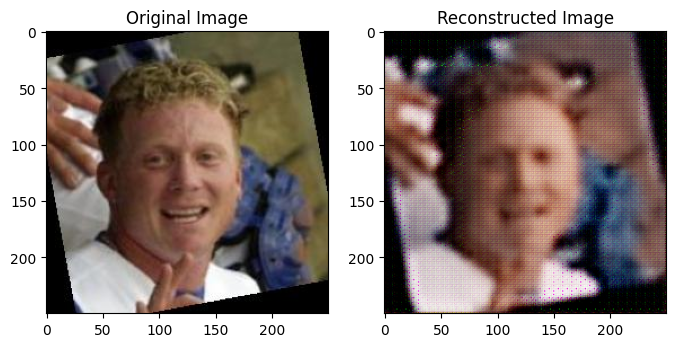

In [66]:
for images, _ in dataloader:
    original_image = images[4]

    # Forward pass through the model
    with torch.no_grad():
        reconstructed_image = model(original_image.unsqueeze(0))  # Add an extra dimension for batch size

    # Convert tensors to numpy arrays for visualization
    original_image_np = original_image.permute(1, 2, 0).cpu().numpy()
    reconstructed_image_np = reconstructed_image.squeeze(0).permute(1, 2, 0).cpu().numpy()

    # Plot the original and reconstructed images side by side
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(original_image_np)
    axes[0].set_title('Original Image')

    axes[1].imshow(reconstructed_image_np)
    axes[1].set_title('Reconstructed Image')

    plt.show()

    break

##  Step 8

In step 7, add a small normaly distrubuted noise to the latent (hidden) representation of the input image and then decode it again. How is adding noise affecting the decoded image ?

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


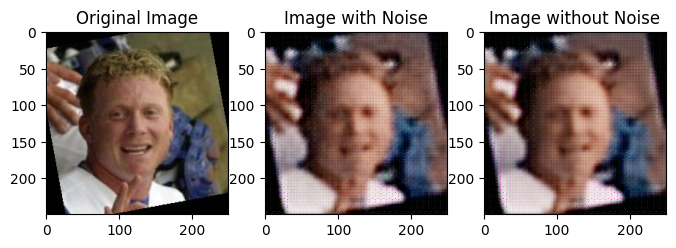

In [68]:
import torch.nn.functional as F

for images, _ in dataloader:
    original_image = images[4]

    latent_space_z = model.encoded_images(original_image.unsqueeze(0))

    #print(latent_space_z)
    
    noisy_latent_space_z = latent_space_z + torch.randn_like(latent_space_z) * 0.1
    #print(noisy_latent_space_z)

    reconstructed_image_noisy = model.decoded_images(noisy_latent_space_z)

    original_image_np = original_image.permute(1, 2, 0).cpu().numpy()
    reconstructed_image_noisy_np = reconstructed_image_noisy.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
    reconstructed_image_without_noise_np = model.decoded_images(latent_space_z).squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
    
    images, axes = plt.subplots(1, 3, figsize=(8, 4))
    axes[0].imshow(original_image_np)
    axes[0].set_title('Original Image')

    axes[1].imshow(reconstructed_image_noisy_np)
    axes[1].set_title('Image with Noise')

    axes[2].imshow(reconstructed_image_without_noise_np)
    axes[2].set_title('Image without Noise')
    

    break

plt.show()

## Step 8 with increased noise

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


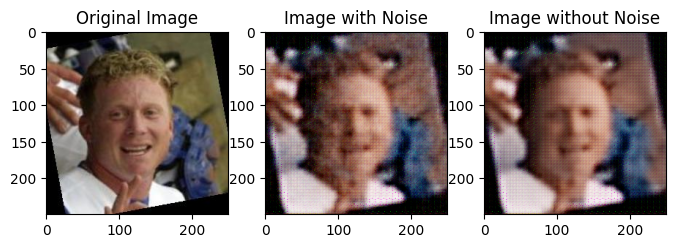

In [70]:
import torch.nn.functional as F

for images, _ in dataloader:
    original_image = images[4]

    latent_space_z = model.encoded_images(original_image.unsqueeze(0))

    #print(latent_space_z)
    
    noisy_latent_space_z = latent_space_z + torch.randn_like(latent_space_z) * 0.2
    #print(noisy_latent_space_z)

    reconstructed_image_noisy = model.decoded_images(noisy_latent_space_z)

    original_image_np = original_image.permute(1, 2, 0).cpu().numpy()
    reconstructed_image_noisy_np = reconstructed_image_noisy.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
    reconstructed_image_without_noise_np = model.decoded_images(latent_space_z).squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
    
    images, axes = plt.subplots(1, 3, figsize=(8, 4))
    axes[0].imshow(original_image_np)
    axes[0].set_title('Original Image')

    axes[1].imshow(reconstructed_image_noisy_np)
    axes[1].set_title('Image with Noise')

    axes[2].imshow(reconstructed_image_without_noise_np)
    axes[2].set_title('Image without Noise')
    

    break

plt.show()

## Step 8
* The Reconstructed image is not getting better upon adding normally distributed noise.
* Upon adding small noise the expectation is that the model should be able to handle the variation and generate better images.
* This may happen if the latent space (z) is not a strong representation of the input image and adding noise make things worse.
* If the latent space is robust then upon adding normally distributed noise the reconstructed image would get denoised and look more similar to the original image.
* To make z robust, we need to train model with more layers or increase epoch or add linear layers.

## Step 3 to 8 with new model1

* Just changed the number of chanels

In [107]:
class AE1(nn.Module):
    
    def __init__(self):
        super(AE1,self).__init__()  
        self.encoded_images = self.encoder()
        self.decoded_images = self.decoder()
        
    def encoder(self):

            return nn.Sequential(nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1), # b, 64, 250, 250
                                 nn.BatchNorm2d(32),  # b, 64, 250, 250
                                 nn.ReLU(True),  # b, 64, 250, 250
                                 nn.MaxPool2d(2, stride=2),  # b, 64, 125, 125
                                 
                                 nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # b, 128, 125, 125
                                 nn.BatchNorm2d(64),  # b, 128, 125, 125
                                 nn.ReLU(True),  # b, 128, 125, 125
                                 nn.MaxPool2d(2, stride=2),  # b, 128, 62,
                                 
                                 nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=2),  # b, 128, 64, 64
                                 nn.BatchNorm2d(128),  # b, 128, 64, 64
                                 nn.ReLU(True),  # b, 128, 64, 64
                                 nn.MaxPool2d(2, stride=2) # b, 128, 32, 32 
                                ) 
            

    # Hout =(Hin −1)×stride[0]−2×padding[0]+dilation[0]×(kernel_size[0]−1)+output_padding[0]+1
    def decoder(self):
        return nn.Sequential(nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1),
                             nn.BatchNorm2d(64),
                             
                             nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1),
                             nn.BatchNorm2d(32),
                             
                             nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
                             nn.Tanh()
                            )
        
    def forward(self,x):
        encoded_images = self.encoded_images(x)
        decoded_images = self.decoded_images(encoded_images)
        return decoded_images
       

In [108]:
# model = AE().to(device)
model1 = AE1()

In [109]:
for x,y in dataloader:
        # ===================forward=====================
    output_encoder1 = model1.encoded_images(x)
    print(output_encoder1.shape)
    output_decoder1 = model1.decoded_images(output_encoder1)
    
    print(output_decoder1.shape)
    output_ae1 = model1.forward(x)
    print(output_ae1.shape)
    break

torch.Size([32, 128, 32, 32])
torch.Size([32, 3, 250, 250])
torch.Size([32, 3, 250, 250])


In [110]:
total_parameters1 = sum(params.numel() for params in model1.parameters())
print(total_parameters1)

187011


## Optimizer and loss function are same

In [111]:
optim1 = torch.optim.Adam(model1.parameters(), lr=0.001, weight_decay=1e-5)

In [112]:
for epoch in range(250):
    total_loss = 0
    for x,y in dataloader:
        # ===================forward=====================
        decoded_images1 = model1.forward(x)
        loss = loss_function(decoded_images1, x)
        
        # ===================backward====================
        
        optim1.zero_grad()
        loss.backward()
        optim1.step()
        total_loss += loss.data
        break;
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch+1, 250, total_loss))

epoch [1/250], loss:0.5588
epoch [2/250], loss:0.4585
epoch [3/250], loss:0.3764
epoch [4/250], loss:0.3275
epoch [5/250], loss:0.2960
epoch [6/250], loss:0.2749
epoch [7/250], loss:0.2602
epoch [8/250], loss:0.2490
epoch [9/250], loss:0.2402
epoch [10/250], loss:0.2330
epoch [11/250], loss:0.2271
epoch [12/250], loss:0.2218
epoch [13/250], loss:0.2169
epoch [14/250], loss:0.2123
epoch [15/250], loss:0.2082
epoch [16/250], loss:0.2041
epoch [17/250], loss:0.2002
epoch [18/250], loss:0.1964
epoch [19/250], loss:0.1927
epoch [20/250], loss:0.1890
epoch [21/250], loss:0.1853
epoch [22/250], loss:0.1817
epoch [23/250], loss:0.1781
epoch [24/250], loss:0.1745
epoch [25/250], loss:0.1710
epoch [26/250], loss:0.1675
epoch [27/250], loss:0.1641
epoch [28/250], loss:0.1607
epoch [29/250], loss:0.1575
epoch [30/250], loss:0.1543
epoch [31/250], loss:0.1512
epoch [32/250], loss:0.1481
epoch [33/250], loss:0.1450
epoch [34/250], loss:0.1421
epoch [35/250], loss:0.1392
epoch [36/250], loss:0.1363
e

In [113]:
torch.save(model1.state_dict(), './generated/conv_autoencoder1.pth')

In [114]:
model1 = AE1()

In [116]:
filepath1 = './generated/conv_autoencoder1.pth'
model1.load_state_dict(torch.load(filepath1))

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


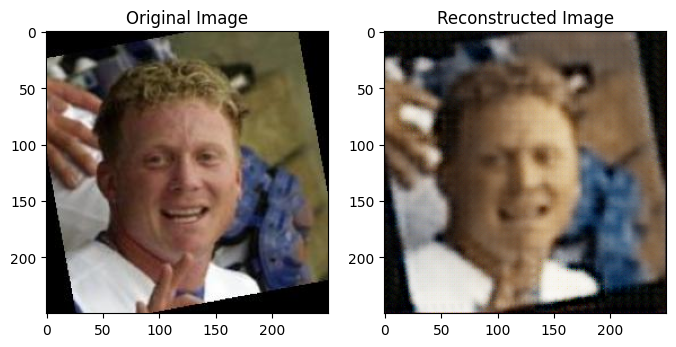

In [117]:
for images, _ in dataloader:
    original_image = images[4]

    # Forward pass through the model
    with torch.no_grad():
        reconstructed_image1 = model1(original_image.unsqueeze(0))  # Add an extra dimension for batch size

    # Convert tensors to numpy arrays for visualization
    original_image_np1 = original_image.permute(1, 2, 0).cpu().numpy()
    reconstructed_image_np1 = reconstructed_image1.squeeze(0).permute(1, 2, 0).cpu().numpy()

    # Plot the original and reconstructed images side by side
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(original_image_np)
    axes[0].set_title('Original Image')

    axes[1].imshow(reconstructed_image_np1)
    axes[1].set_title('Reconstructed Image')

    plt.show()

    break

##  Step 8

In step 7, add a small normaly distrubuted noise to the latent (hidden) representation of the input image and then decode it again. How is adding noise affecting the decoded image ?

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


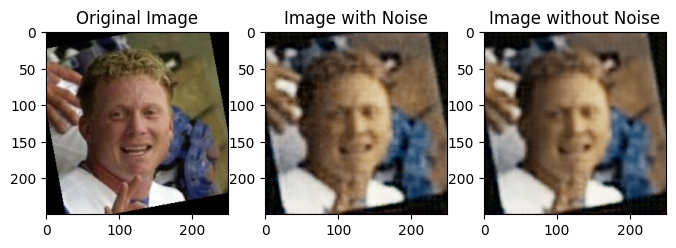

In [118]:
for images, _ in dataloader:
    
    original_image = images[4]

    latent_space_z1 = model1.encoded_images(original_image.unsqueeze(0))

    #print(latent_space_z)
    
    noisy_latent_space_z1 = latent_space_z1 + torch.randn_like(latent_space_z1) * 0.1
    #print(noisy_latent_space_z)

    reconstructed_image_noisy1 = model1.decoded_images(noisy_latent_space_z1)

    original_image_np1 = original_image.permute(1, 2, 0).cpu().numpy()
    reconstructed_image_noisy_np1 = reconstructed_image_noisy1.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
    reconstructed_image_without_noise_np1 = model1.decoded_images(latent_space_z1).squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
    
    images, axes = plt.subplots(1, 3, figsize=(8, 4))
    axes[0].imshow(original_image_np)
    axes[0].set_title('Original Image')

    axes[1].imshow(reconstructed_image_noisy_np1)
    axes[1].set_title('Image with Noise')

    axes[2].imshow(reconstructed_image_without_noise_np1)
    axes[2].set_title('Image without Noise')
    

    break

plt.show()

## Step 8 with increased noise.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


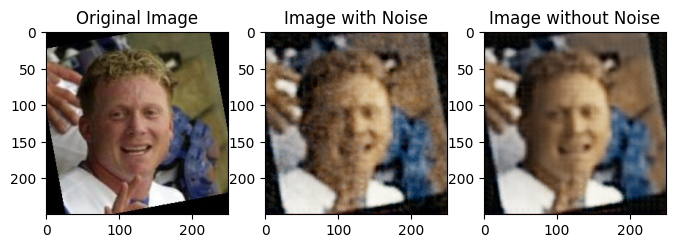

In [119]:
for images, _ in dataloader:
    
    original_image = images[4]

    latent_space_z1 = model1.encoded_images(original_image.unsqueeze(0))

    #print(latent_space_z)
    
    noisy_latent_space_z1 = latent_space_z1 + torch.randn_like(latent_space_z1) * 0.2
    #print(noisy_latent_space_z)

    reconstructed_image_noisy1 = model1.decoded_images(noisy_latent_space_z1)

    original_image_np1 = original_image.permute(1, 2, 0).cpu().numpy()
    reconstructed_image_noisy_np1 = reconstructed_image_noisy1.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
    reconstructed_image_without_noise_np1 = model1.decoded_images(latent_space_z1).squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
    
    images, axes = plt.subplots(1, 3, figsize=(8, 4))
    axes[0].imshow(original_image_np)
    axes[0].set_title('Original Image')

    axes[1].imshow(reconstructed_image_noisy_np1)
    axes[1].set_title('Image with Noise')

    axes[2].imshow(reconstructed_image_without_noise_np1)
    axes[2].set_title('Image without Noise')
    

    break

plt.show()

## Step 3 to 8 with model2

* Changed the architecture.
* Increased color channels but reduced the height and width of image.
* Ultimately reduced the latent space by 2.86 of original

In [47]:
class AE2(nn.Module):
    
    def __init__(self):
        super(AE2,self).__init__()  
        self.encoded_images = self.encoder()
        self.decoded_images = self.decoder()
        
    def encoder(self):

            return nn.Sequential(nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1), # b, 64, 250, 250
                                 nn.BatchNorm2d(32),  # b, 64, 250, 250
                                 nn.ReLU(True),  # b, 64, 250, 250
                                 nn.MaxPool2d(2, stride=2),  # b, 64, 125, 125
                                 
                                 nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # b, 128, 125, 125
                                 nn.BatchNorm2d(64),  # b, 128, 125, 125
                                 nn.ReLU(True),  # b, 128, 125, 125
                                 nn.MaxPool2d(2, stride=2),  # b, 128, 62,
                                 
                                 nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=2),  # b, 128, 64, 64
                                 nn.BatchNorm2d(128),  # b, 128, 64, 64
                                 nn.ReLU(True),  # b, 128, 64, 64
                                 nn.MaxPool2d(2, stride=2), # b, 128, 32, 32

                                 nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),  # b, 256, 32, 32
                                 nn.BatchNorm2d(128),  # b, 256, 32, 32
                                 nn.ReLU(True),  # b, 256, 32, 32
                                 nn.MaxPool2d(2, stride=2) # b, 256, 16, 16
                                ) 
            

    # Hout =(Hin −1)×stride[0]−2×padding[0]+dilation[0]×(kernel_size[0]−1)+output_padding[0]+1
    def decoder(self):
        return nn.Sequential(nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1), #b, 128, 31, 31
                             nn.BatchNorm2d(64), #b, 128, 31, 31
                             
                             nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1), #b, 64, 62, 62
                             nn.BatchNorm2d(32), #b, 64, 62, 62
                             
                             nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1), #b, 32, 124, 124
                             nn.BatchNorm2d(16), #b, 32, 124, 124

                             nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, output_padding=1), #b, 3, 250, 250
                             nn.Tanh()
                            )
        
    def forward(self,x):
        encoded_images = self.encoded_images(x)
        decoded_images = self.decoded_images(encoded_images)
        return decoded_images
       

In [48]:
model2 = AE2()

In [49]:
for x,y in dataloader:
        # ===================forward=====================
    output_encoder2 = model2.encoded_images(x)
    print(output_encoder2.shape)
    output_decoder2 = model2.decoded_images(output_encoder2)
    
    print(output_decoder2.shape)
    output_ae2 = model.forward(x)
    print(output_ae2.shape)
    break

torch.Size([32, 128, 16, 16])
torch.Size([32, 3, 250, 250])
torch.Size([32, 3, 250, 250])


In [50]:
#(print(params.numel().shape) for params in model2.parameters())

for params in model2.parameters():
    print(params.shape)
    


torch.Size([32, 3, 3, 3])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([64, 32, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64, 32, 3, 3])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32, 16, 3, 3])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16, 3, 3, 3])
torch.Size([3])


In [51]:
total_parameters2 = sum(params.numel() for params in model2.parameters())
print(total_parameters2)

339075


## Optimizer and loss function are same

In [52]:
optim2 = torch.optim.Adam(model2.parameters(), lr=0.001, weight_decay=1e-5)

In [53]:
for epoch in range(100):
    total_loss = 0
    for x,y in dataloader:
        # ===================forward=====================
        decoded_images2 = model2.forward(x)
        loss = loss_function(decoded_images2, x)
        
        # ===================backward====================
        
        optim2.zero_grad()
        loss.backward()
        optim2.step()
        total_loss += loss.data
        break;
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch+1, 100, total_loss))

epoch [1/100], loss:0.3778
epoch [2/100], loss:0.2962
epoch [3/100], loss:0.2530
epoch [4/100], loss:0.2307
epoch [5/100], loss:0.2159
epoch [6/100], loss:0.2036
epoch [7/100], loss:0.1926
epoch [8/100], loss:0.1829
epoch [9/100], loss:0.1742
epoch [10/100], loss:0.1662
epoch [11/100], loss:0.1589
epoch [12/100], loss:0.1523
epoch [13/100], loss:0.1464
epoch [14/100], loss:0.1412
epoch [15/100], loss:0.1365
epoch [16/100], loss:0.1323
epoch [17/100], loss:0.1287
epoch [18/100], loss:0.1256
epoch [19/100], loss:0.1227
epoch [20/100], loss:0.1202
epoch [21/100], loss:0.1177
epoch [22/100], loss:0.1153
epoch [23/100], loss:0.1130
epoch [24/100], loss:0.1108
epoch [25/100], loss:0.1085
epoch [26/100], loss:0.1063
epoch [27/100], loss:0.1043
epoch [28/100], loss:0.1023
epoch [29/100], loss:0.1003
epoch [30/100], loss:0.0984
epoch [31/100], loss:0.0966
epoch [32/100], loss:0.0949
epoch [33/100], loss:0.0933
epoch [34/100], loss:0.0916
epoch [35/100], loss:0.0901
epoch [36/100], loss:0.0885
e

In [79]:
torch.save(model2.state_dict(), './generated/conv_autoencoder2.pth')

In [99]:
model2 = AE2()

In [100]:
filepath2 = './generated/conv_autoencoder2.pth'
model2.load_state_dict(torch.load(filepath2))

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


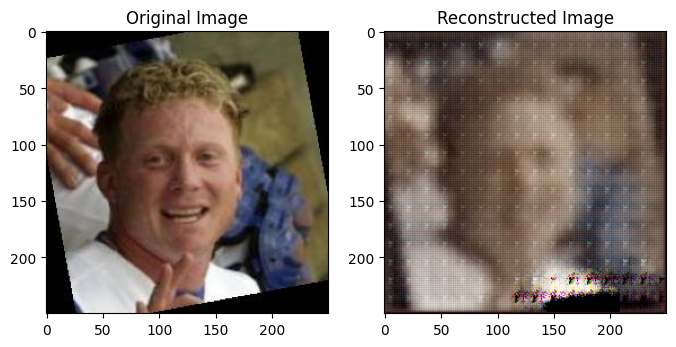

In [106]:
for images, _ in dataloader:
    original_image = images[4]

    # Forward pass through the model
    with torch.no_grad():
        reconstructed_image2 = model2(original_image.unsqueeze(0))  # Add an extra dimension for batch size

    # Convert tensors to numpy arrays for visualization
    original_image_np = original_image.permute(1, 2, 0).cpu().numpy()
    reconstructed_image_np2 = reconstructed_image2.squeeze(0).permute(1, 2, 0).cpu().numpy()

    # Plot the original and reconstructed images side by side
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(original_image_np)
    axes[0].set_title('Original Image')

    axes[1].imshow(reconstructed_image_np2)
    axes[1].set_title('Reconstructed Image')

    plt.show()

    break

##  Step 8

In step 7, add a small normaly distrubuted noise to the latent (hidden) representation of the input image and then decode it again. How is adding noise affecting the decoded image ?

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


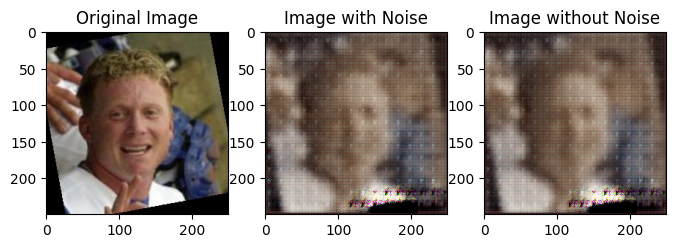

In [104]:
for images, _ in dataloader:
    
    original_image = images[4]

    latent_space_z2 = model2.encoded_images(original_image.unsqueeze(0))

    #print(latent_space_z)
    
    noisy_latent_space_z2 = latent_space_z2 + torch.randn_like(latent_space_z2) * 0.1
    #print(noisy_latent_space_z)

    reconstructed_image_noisy2 = model2.decoded_images(noisy_latent_space_z2)

    original_image_np2 = original_image.permute(1, 2, 0).cpu().numpy()
    reconstructed_image_noisy_np2 = reconstructed_image_noisy2.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
    reconstructed_image_without_noise_np2 = model2.decoded_images(latent_space_z2).squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
    
    images, axes = plt.subplots(1, 3, figsize=(8, 4))
    axes[0].imshow(original_image_np)
    axes[0].set_title('Original Image')

    axes[1].imshow(reconstructed_image_noisy_np2)
    axes[1].set_title('Image with Noise')

    axes[2].imshow(reconstructed_image_without_noise_np2)
    axes[2].set_title('Image without Noise')
    

    break

plt.show()

## Step 8 with increased noise.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


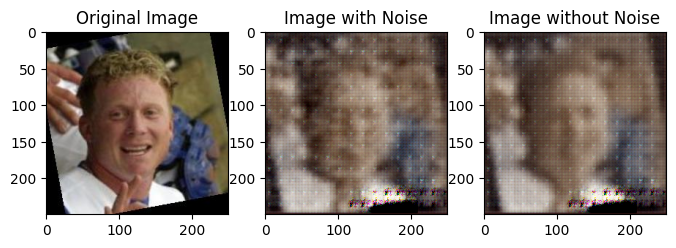

In [105]:
for images, _ in dataloader:
    
    original_image = images[4]

    latent_space_z2 = model2.encoded_images(original_image.unsqueeze(0))

    #print(latent_space_z)
    
    noisy_latent_space_z2 = latent_space_z2 + torch.randn_like(latent_space_z2) * 0.2
    #print(noisy_latent_space_z)

    reconstructed_image_noisy2 = model2.decoded_images(noisy_latent_space_z2)

    original_image_np2 = original_image.permute(1, 2, 0).cpu().numpy()
    reconstructed_image_noisy_np2 = reconstructed_image_noisy2.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
    reconstructed_image_without_noise_np2 = model2.decoded_images(latent_space_z2).squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
    
    images, axes = plt.subplots(1, 3, figsize=(8, 4))
    axes[0].imshow(original_image_np)
    axes[0].set_title('Original Image')

    axes[1].imshow(reconstructed_image_noisy_np2)
    axes[1].set_title('Image with Noise')

    axes[2].imshow(reconstructed_image_without_noise_np2)
    axes[2].set_title('Image without Noise')
    

    break

plt.show()